In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 데이터 디렉토리 설정
train_dir='C:/Users/KOREAVC/Downloads/osteoarthritis/train'
val_dir='C:/Users/KOREAVC/Downloads/osteoarthritis/val'
test_dir='C:/Users/KOREAVC/Downloads/osteoarthritis/test'
autest_dir='C:/Users/KOREAVC/Downloads/osteoarthritis/auto_test'

categories = ['0', '1', '2', '3', '4']

# 데이터 및 라벨 리스트 초기화
train_data = []
train_labels = []

# 각 카테고리 디렉토리에서 이미지 로드
for category in categories:
    category_path = os.path.join(train_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_path[:2000]):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 이미지를 회색조로 변환
        resized_img = cv2.resize(gray_img, (224, 224))  # 이미지 크기 조정
        img_array = np.expand_dims(resized_img, axis=-1)  # 채널 차원 추가 (224, 224, 1)
        train_data.append(img_array)
        train_labels.append(label)

val_data = []
val_labels = []

for category in categories:
    category_path = os.path.join(val_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 이미지를 회색조로 변환
        resized_img = cv2.resize(gray_img, (224, 224))  # 이미지 크기 조정
        img_array = np.expand_dims(resized_img, axis=-1)  # 채널 차원 추가 (224, 224, 1)
        val_data.append(img_array)
        val_labels.append(label)

test_data = []
test_labels = []
for category in categories:
    category_path = os.path.join(test_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 이미지를 회색조로 변환
        resized_img = cv2.resize(gray_img, (224, 224))  # 이미지 크기 조정
        img_array = np.expand_dims(resized_img, axis=-1)  # 채널 차원 추가 (224, 224, 1)
        test_data.append(img_array)
        test_labels.append(label)
        
for category in categories:
    category_path = os.path.join(autest_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 이미지를 회색조로 변환
        resized_img = cv2.resize(gray_img, (224, 224))  # 이미지 크기 조정
        img_array = np.expand_dims(resized_img, axis=-1)  # 채널 차원 추가 (224, 224, 1)
        test_data.append(img_array)
        test_labels.append(label)



# 데이터를 numpy 배열로 변환
train_data = np.array(train_data, dtype="float") / 255.0
train_labels = np.array(train_labels)
val_data = np.array(val_data, dtype="float") / 255.0
val_labels = np.array(val_labels)
test_data = np.array(test_data, dtype="float") / 255.0
test_labels = np.array(test_labels)

tr_labels = []
te_labels = []
v_labels = []

# 5클래스 > 3클래스
for i in train_labels:
    if i in [0,1]:
        tr_labels.append(0)
    elif i in [2,3]:
        tr_labels.append(1)
    elif i == 4:
        tr_labels.append(2)
        
for i in val_labels:
    if i in [0,1]:
        v_labels.append(0)
    elif i in [2,3]:
        v_labels.append(1)
    elif i == 4:
        v_labels.append(2)
        
for i in test_labels:
    if i in [0,1]:
        te_labels.append(0)
    elif i in [2,3]:
        te_labels.append(1)
    elif i == 4:
        te_labels.append(2)


# 원-핫 인코딩 라벨
tr_labels = to_categorical(tr_labels, num_classes=3)
v_labels = to_categorical(v_labels, num_classes=3)
te_labels = to_categorical(te_labels, num_classes=3)

In [10]:
print(train_data.shape)
print(tr_labels.shape)
print(val_data.shape)
print(v_labels.shape)
print(test_data.shape)
print(te_labels.shape)

(6644, 224, 224, 1)
(6644, 3)
(826, 224, 224, 1)
(826, 3)
(3182, 224, 224, 1)
(3182, 3)


In [11]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import categorical_crossentropy

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (possible_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

BATCH_SIZE = 32

In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# 회색조 이미지 입력을 위한 입력 레이어 정의
input_tensor = Input(shape=(224, 224, 1))

# InceptionV3 모델 불러오기 (채널을 3으로 맞추기 위해 반복)
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Concatenate()([input_tensor]*3))

# 새로운 최상위 층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# 전체 모델 구성
model = Model(inputs=input_tensor, outputs=predictions)

# 기본 모델의 가중치를 학습하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = model.fit(
    train_data, tr_labels,
    validation_data=(val_data, v_labels),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
208/208 [==============================] - 97s 451ms/step - loss: 0.8246 - accuracy: 0.6737 - recall_m: 0.6527 - precision_m: 0.6832 - f1_m: 0.6672 - val_loss: 0.6242 - val_accuracy: 0.7119 - val_recall_m: 0.6933 - val_precision_m: 0.7104 - val_f1_m: 0.7016
Epoch 2/30
208/208 [==============================] - 94s 454ms/step - loss: 0.5438 - accuracy: 0.7378 - recall_m: 0.7262 - precision_m: 0.7453 - f1_m: 0.7354 - val_loss: 0.5749 - val_accuracy: 0.7324 - val_recall_m: 0.7234 - val_precision_m: 0.7315 - val_f1_m: 0.7273
Epoch 3/30
208/208 [==============================] - 94s 451ms/step - loss: 0.5101 - accuracy: 0.7640 - recall_m: 0.7565 - precision_m: 0.7691 - f1_m: 0.7626 - val_loss: 0.6385 - val_accuracy: 0.6864 - val_recall_m: 0.6711 - val_precision_m: 0.6949 - val_f1_m: 0.6826
Epoch 4/30
208/208 [==============================] - 102s 489ms/step - loss: 0.5024 - accuracy: 0.7628 - recall_m: 0.7544 - precision_m: 0.7648 - f1_m: 0.7595 - val_loss: 0.6049 - val_accuracy

In [17]:
import matplotlib.pyplot as plt
import numpy as np
model.load_weights('best_model.h5')
predictions = model.predict(test_data)
predicted_class = np.argmax(predictions, axis=1)
true_classes = te_labels
print(predicted_class[:20])
print(true_classes[:20])

100/100 [==============================] - 39s 392ms/step
[0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [18]:
# predicted_class = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_classes, axis=1)


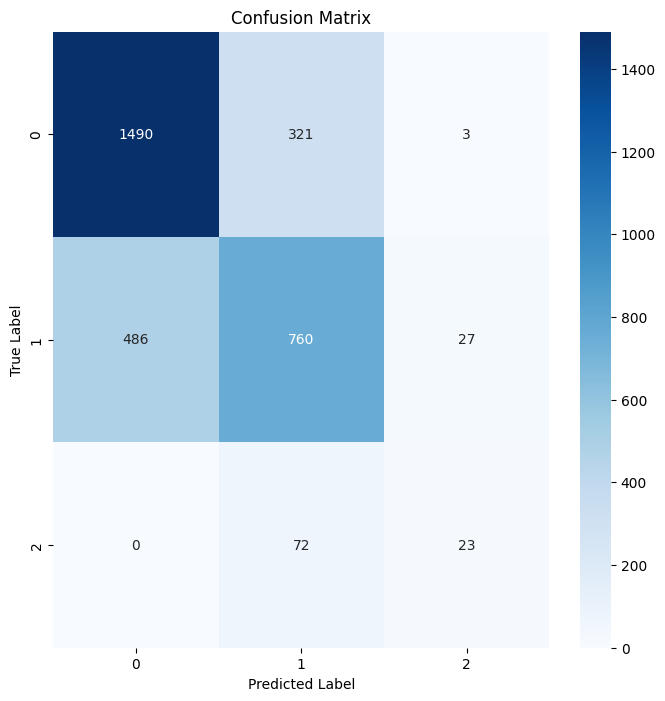

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(true_classes, predicted_class)
plt.figure(figsize=(8, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()